In [1]:
import pandas as pd
import numpy as np
import scipy
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import netcomp as nc

In [2]:
##Load original data
full_energyharvestertensor = pd.read_excel(r'C:\Users\nandy\Downloads\functionalmodels\functionalmodels\energy_harvesters_tensor.xls', sheet_name=None, header=1, index_col=0) 
energyharvestertensor = pd.concat(full_energyharvestertensor, axis=1)
#appliancestensor = pd.read_csv(r'C:\Users\nandy\source\repos\FunctionalModelSimilarity\FunctionalModelSimilarity\data\02_intermediate\appliances_and_toys_adjacencymatrix_V2.csv', header=[0,1], index_col=0) 
#appliancestensor = appliancestensor.stack(0)
#appliancestensor = appliancestensor.unstack(0)
#energyharvestertensor = appliancestensor

# Expanding Data Using Probability Distribution

In [3]:
def functionflowprobability(df):
    probabilities = df.sum(axis=0)/df.shape[0]
    return probabilities.unstack()

In [4]:
prob_energyharvester = functionflowprobability(energyharvestertensor)

In [5]:
nobs_vec = [1000, 10000, 100000] #Size of dataset

In [6]:
def create_dataset(theta, nobs): #dictionary
    #theta is the probability of function-flow pair existing
    #nobs is the size of the dataset
    expanded_data = {}
    graphs = {}
    adj_matrices = {}
    for i in range(0, nobs):
        np.random.seed(i)
        Y = pd.DataFrame(np.random.binomial(n=1, p=theta), index=theta.index, columns=theta.columns)
        expanded_data[i] = Y
        df2 = pd.concat([expanded_data[i], expanded_data[i].T], sort=True).fillna(0).sort_index() #ADDED a sort - energy harvesters rerun using tag "sorted" ... :(
        graphs[i] = nx.from_numpy_matrix(df2.values)
        adj_matrices[i] = nx.adjacency_matrix(graphs[i])
        mapping = dict(zip(graphs[i], df2.columns.values)) 
        graphs[i] = nx.relabel_nodes(graphs[i], mapping)
    return graphs, adj_matrices

In [7]:
g, a = create_dataset(prob_energyharvester, nobs_vec[0])

# Graph Properties

In [8]:
def maxofdict(d):
    mx_pair = max(zip(d.values(), d.keys()))
    return mx_pair

In [9]:
properties = pd.DataFrame()
for key in g:
    X, Y = nx.algorithms.bipartite.sets(g[key])
    deg_centrality = nx.algorithms.bipartite.centrality.degree_centrality(g[key],X)
    cent, nname = maxofdict(deg_centrality)
    properties.loc[key, "max_deg_centrality"] = cent
    properties.loc[key, "avg_deg_centrality"] = sum(deg_centrality.values())/len(deg_centrality)
    max_degree = nx.adjacency_matrix(g[key]).sum(axis=1).max()
    properties.loc[key, "max_degree"] = max_degree
    max_deg_nodes = [item[0] for item in g[key].degree() if item[1] == max_degree]
    max_deg_nodes_str = ','.join(max_deg_nodes)
    properties.loc[key, "max_deg_nodes"] = max_deg_nodes_str
    complexity = a[key].sum().sum()/2
    properties.loc[key, "complexity"] = complexity
    bi_clustering = nx.algorithms.bipartite.cluster.average_clustering(g[key])
    properties.loc[key, "bipartite clustering coeff"] = bi_clustering
    

(array([  4.,  30., 110., 221., 248., 202., 114.,  49.,  18.,   4.]),
 array([0.22712355, 0.23606061, 0.24499767, 0.25393473, 0.26287178,
        0.27180884, 0.2807459 , 0.28968295, 0.29862001, 0.30755707,
        0.31649412]),
 <a list of 10 Patch objects>)

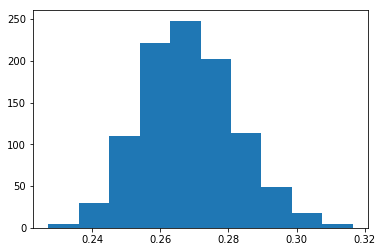

In [10]:
plt.hist(properties["bipartite clustering coeff"])

# Testing Graph Distances on Larger Dataset

In [60]:
df = pd.DataFrame()
for key1 in a:
    for key2 in a:
        A1 = a[key1]
        A2 = a[key2]
        d = nc.lambda_dist(A1,A2,kind='laplacian')
        df.loc[key1, key2] = d
df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.000000,3.741398,6.583571,5.649727,4.163598,4.764293,5.196858,4.677851,6.456252,6.718229,...,5.975338,4.141873,6.257522,4.943615,4.726777,3.353974,4.822401,5.085010,4.190306,5.995793
1,3.741398,0.000000,4.828650,4.066145,3.628028,3.290230,3.859171,2.941110,4.238119,4.373992,...,4.173917,3.173084,4.299587,3.448101,7.311371,2.944419,3.214633,3.837838,2.944187,4.921595
2,6.583571,4.828650,0.000000,2.663360,4.373961,5.625016,4.016957,3.272746,5.048475,2.168751,...,3.876289,3.689585,3.363322,3.893763,10.753432,5.110971,3.537650,2.709855,3.861227,6.181539
3,5.649727,4.066145,2.663360,0.000000,4.441326,4.696330,3.857928,2.639013,5.057825,3.015463,...,3.856141,2.986243,3.049674,3.867046,9.701384,4.207501,2.932115,2.497052,3.034888,6.307721
4,4.163598,3.628028,4.373961,4.441326,0.000000,3.567128,2.473852,2.817851,3.903492,4.035405,...,3.346523,2.674375,3.620023,2.910578,8.187174,2.775276,3.458384,3.370042,3.070175,3.560694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,3.353974,2.944419,5.110971,4.207501,2.775276,2.138696,3.016185,2.549284,4.248227,4.693398,...,3.462008,2.570587,3.853181,3.726994,6.974407,0.000000,2.900210,3.839404,1.960305,4.337106
496,4.822401,3.214633,3.537650,2.932115,3.458384,3.410412,3.630489,2.444143,4.778056,3.591155,...,3.448084,2.118235,3.375265,3.855234,8.313407,2.900210,0.000000,3.319007,2.198319,5.381384
497,5.085010,3.837838,2.709855,2.497052,3.370042,4.627754,2.574537,2.195783,4.036749,3.046986,...,3.275753,2.699397,2.971335,3.052549,9.406363,3.839404,3.319007,0.000000,2.883988,4.874642
498,4.190306,2.944187,3.861227,3.034888,3.070175,2.755821,2.976401,1.761911,3.914233,3.654097,...,2.645937,2.613873,3.142679,3.427704,7.962708,1.960305,2.198319,2.883988,0.000000,4.568973


In [39]:
import itertools

def dist(a1,a2):
    d = nc.lambda_dist(a1,a2,kind='laplacian')
    return d

[dist(*map(a.get, item)) for item in itertools.combinations(a,2)]

In [11]:
def create_dataset(theta, nobs): #np 3D array instead of dictionary
    #theta is the probability of function-flow pair existing
    #nobs is the size of the dataset
    expanded_data = {}
    graphs = {}
    adj_matrices = {}
    adj_array = []
    for i in range(0, nobs):
        np.random.seed(i)
        Y = pd.DataFrame(np.random.binomial(n=1, p=theta), index=theta.index, columns=theta.columns)
        expanded_data[i] = Y
        df2 = pd.concat([expanded_data[i], expanded_data[i].T], sort=True).fillna(0).sort_index() #ADDED a sort - energy harvesters rerun using tag "sorted" ... :(
        graphs[i] = nx.from_numpy_matrix(df2.values)
        adj_array.append(df2.values)
        adj_matrices[i] = nx.adjacency_matrix(graphs[i])
        mapping = dict(zip(graphs[i], df2.columns.values)) 
        graphs[i] = nx.relabel_nodes(graphs[i], mapping)
    return graphs, adj_matrices, np.array(adj_array)

In [12]:
g2, a2, arr = create_dataset(prob_energyharvester, nobs_vec[0])

In [13]:
arr.shape

(1000, 37, 37)

In [14]:
arr[0,:,:].shape

(37, 37)

In [92]:
import numba as nb
@nb.jit()
def testfun(arr):
    df = np.zeros((arr.shape[0],arr.shape[0]))
    for i in range(0, arr.shape[0]):
        for j in range(0, arr.shape[0]):
            A1 = arr[i,:,:]
            A2 = arr[j,:,:]
            d = nc.lambda_dist(A1,A2,kind='laplacian')
            df[i,j] = d
    return df

print(testfun(arr).shape)

<ipython-input-92-daf03ee3e357>:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "testfun" failed type inference due to: Unknown attribute 'lambda_dist' of type Module(<module 'netcomp' from 'C:\\Users\\nandy\\Anaconda3\\envs\\test_env\\lib\\site-packages\\netcomp\\__init__.py'>)

File "<ipython-input-92-daf03ee3e357>", line 10:
def testfun(arr):
    <source elided>
            A2 = arr[j,:,:]
            d = nc.lambda_dist(A1,A2,kind='laplacian')
            ^

[1] During: typing of get attribute at <ipython-input-92-daf03ee3e357> (10)

File "<ipython-input-92-daf03ee3e357>", line 10:
def testfun(arr):
    <source elided>
            A2 = arr[j,:,:]
            d = nc.lambda_dist(A1,A2,kind='laplacian')
            ^

  @nb.jit()
<ipython-input-92-daf03ee3e357>:2: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "testfun" failed type inference due to: cannot determine Numba type

(1000, 1000)


C:\Users\nandy\Anaconda3\envs\test_env\lib\site-packages\numba\compiler.py:742: NumbaWarning: Function "testfun" was compiled in object mode without forceobj=True.

File "<ipython-input-92-daf03ee3e357>", line 6:
def testfun(arr):
    <source elided>
    print(df.shape)
    for i in range(0, arr.shape[0]):
    ^

  self.func_ir.loc))
C:\Users\nandy\Anaconda3\envs\test_env\lib\site-packages\numba\compiler.py:751: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "<ipython-input-92-daf03ee3e357>", line 6:
def testfun(arr):
    <source elided>
    print(df.shape)
    for i in range(0, arr.shape[0]):
    ^

  warnings.warn(errors.NumbaDeprecationWarning(msg, self.func_ir.loc))


(1000, 1000)


# Looking for Bipartite-specific Properties

(array([512.,   0.,   0., 403.,   0.,   0.,   0.,   0.,   0.,  85.]),
 array([0.3128655 , 0.31342419, 0.31398287, 0.31454156, 0.31510025,
        0.31565894, 0.31621763, 0.31677632, 0.317335  , 0.31789369,
        0.31845238]),
 <a list of 10 Patch objects>)

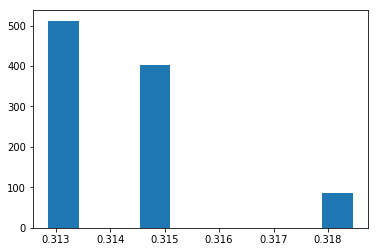

In [15]:
from networkx.algorithms import bipartite
test = []
for i in range(0,1000):
    G = g2[i]
    #print(bipartite.is_bipartite(G))
    X, Y = bipartite.sets(G)
    list(X), list(Y)
    Gc = max(nx.connected_component_subgraphs(g2[i]), key=len)
    #print(len(list(Gc.nodes())))
    #print(len(list(nx.connected_component_subgraphs(g2[i]))))
    test.append(bipartite.basic.density(g2[99],X))

plt.hist(test)

C:\Users\nandy\Anaconda3\envs\test_env\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
C:\Users\nandy\Anaconda3\envs\test_env\lib\site-packages\networkx\drawing\nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
C:\Users\nandy\Anaconda3\envs\test_env\lib\site-packages\networkx\drawing\nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
C:\Users\nandy\Anaconda3\envs\test_env\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot

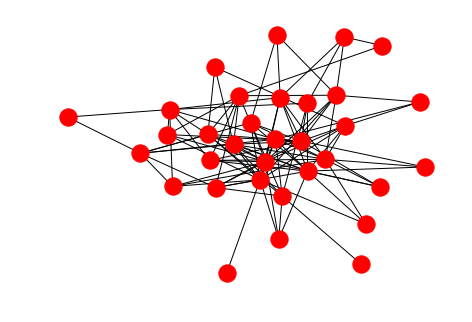

In [16]:
Gc = max(nx.connected_component_subgraphs(g2[99]), key=len)
nx.draw(Gc)

# Perturbation

In [10]:
np.random.seed(9999)
index = energyharvestertensor.iloc[np.random.randint(energyharvestertensor.shape[0])].name
np.random.seed(9998)
sourcename = energyharvestertensor.iloc[np.random.randint(energyharvestertensor.shape[0])].name
index, sourcename
#index = "Presto Popcorn Popper"
#sourcename = "Horseman Swimming Toy"

('Columbia Power Manta buoy', 'Tracking system')

In [11]:
##try new method - swapping or negating rows to test global vs local structure (only done on one functional model)
negated1 = {}
negated2 = {}
swapped = {}
graphs_n1 = {}
adj_matrices_n1 = {}
graphs_n2 = {}
adj_matrices_n2 = {}
graphs_s = {}
adj_matrices_s = {}

original = energyharvestertensor.loc[index].unstack()
orig_df = pd.concat([original, original.T], sort=True).fillna(0).sort_index()
orig_g = nx.from_numpy_matrix(orig_df.values)
orig_adj = nx.adjacency_matrix(orig_g)

for j in range(0,original.shape[1]):
    for k in range(0, original.shape[1]):
        if k>j:
            modified = original.copy()
            name = str(j)+str(k)
            cols1, cols2 = np.logical_not(modified.iloc[:,j].copy()).astype(int), modified.iloc[:,k].copy()
            modified.iloc[:,j], modified.iloc[:,k] = cols1.values, cols2.values
            negated1[name] = modified
            df2 = pd.concat([negated1[name], negated1[name].T], sort=True).fillna(0).sort_index() #ADDED a sort - energy harvesters rerun using tag "sorted" ... :(
            graphs_n1[name] = nx.from_numpy_matrix(df2.values)
            adj_matrices_n1[name] = nx.adjacency_matrix(graphs_n1[name])
            mapping = dict(zip(graphs_n1[name], df2.columns.values)) 
            graphs_n1[name] = nx.relabel_nodes(graphs_n1[name], mapping)
for j in range(0,original.shape[1]):
    for k in range(0, original.shape[1]):
        if k>j:
            modified = original.copy()
            name = str(j)+str(k)
            cols1, cols2 = np.logical_not(modified.iloc[:,j].copy()).astype(int), np.logical_not(modified.iloc[:,k].copy()).astype(int)
            modified.iloc[:,j], modified.iloc[:,k] = cols1.values, cols2.values
            negated2[name] = modified
            df2 = pd.concat([negated2[name], negated2[name].T], sort=True).fillna(0).sort_index() #ADDED a sort - energy harvesters rerun using tag "sorted" ... :(
            graphs_n2[name] = nx.from_numpy_matrix(df2.values)
            adj_matrices_n2[name] = nx.adjacency_matrix(graphs_n2[name])
            mapping = dict(zip(graphs_n2[name], df2.columns.values)) 
            graphs_n2[name] = nx.relabel_nodes(graphs_n2[name], mapping)
for j in range(0,original.shape[1]):
    for k in range(0, original.shape[1]):
        if k>j:
            modified = original.copy()
            name = str(j)+str(k)
            cols1, cols2 = modified.iloc[:,j].copy(), modified.iloc[:,k].copy()
            modified.iloc[:,j], modified.iloc[:,k] = cols2.values, cols1.values
            swapped[name] = modified
            df2 = pd.concat([swapped[name], swapped[name].T], sort=True).fillna(0).sort_index() #ADDED a sort - energy harvesters rerun using tag "sorted" ... :(
            graphs_s[name] = nx.from_numpy_matrix(df2.values)
            adj_matrices_s[name] = nx.adjacency_matrix(graphs_s[name])
            mapping = dict(zip(graphs_s[name], df2.columns.values)) 
            graphs_s[name] = nx.relabel_nodes(graphs_s[name], mapping) 

In [3]:
def range_normalize(data):
    normalized = 1 - ((data - data.min().min())/(data.max().max() - data.min().min()))
    return normalized

In [18]:
df1 = pd.DataFrame()
A1 = orig_adj
for key in adj_matrices_n1:
        A2 = adj_matrices_n1[key]
        d1 = nc.lambda_dist(A1,A2,kind='laplacian')
        df1.loc["Flip 1 Column", key] = d1
        A3 = adj_matrices_s[key]
        d2 = nc.lambda_dist(A1, A3, kind='laplacian')
        df1.loc["Swap Columns", key] = d2 
        A4 = adj_matrices_n2[key]
        d3 = nc.lambda_dist(A1, A4, kind='laplacian')
        df1.loc["Flip 2 Columns", key] = d3
df1

,01,02,03,04,05,06,07,08,09,010,...,1112,1113,1114,1115,1213,1214,1215,1314,1315,1415
Flip 1 Column,12.752382,12.752382,1.275238e+01,12.752382,12.752382,12.752382,12.752382,12.752382,12.752382,12.752382,...,4.472136,4.472136e+00,4.472136,4.472136e+00,4.472136,4.472136,4.472136,12.752382,12.752382,4.472136
Swap Columns,0.000000,0.000000,9.057678e-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.407139e-14,0.000000,1.407139e-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Flip 2 Columns,21.013757,21.013757,1.242604e+01,21.013757,21.013757,12.426045,21.013757,21.013757,12.426045,12.426045,...,9.055385,1.242604e+01,9.055385,1.242604e+01,12.426045,9.055385,12.426045,12.426045,21.013757,12.426045


In [55]:
df2 = pd.DataFrame()
A1 = orig_adj
for key in adj_matrices_n1:
        A2 = adj_matrices_n1[key]
        d1 = nc.edit_distance(A1,A2)
        df2.loc["Flip 1 Column", key] = d1
        A3 = adj_matrices_s[key]
        d2 = nc.edit_distance(A1, A3)
        df2.loc["Swap Columns", key] = d2 
        A4 = adj_matrices_n2[key]
        d3 = nc.edit_distance(A1, A4)
        df2.loc["Flip 2 Columns", key] = d3
df2

,01,02,03,04,05,06,07,08,09,010,...,1516,1517,1518,1519,1617,1618,1619,1718,1719,1819
Flip 1 Column,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,...,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
Swap Columns,6.0,4.0,2.0,8.0,2.0,2.0,6.0,2.0,2.0,2.0,...,0.0,0.0,2.0,6.0,0.0,2.0,6.0,2.0,6.0,8.0
Flip 2 Columns,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,...,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0


In [56]:
df3 = pd.DataFrame()
A1 = orig_adj
for key in adj_matrices_n1:
        A2 = adj_matrices_n1[key]
        d1 = nc.deltacon0(A1,A2)
        df3.loc["Flip 1 Column", key] = d1
        A3 = adj_matrices_s[key]
        d2 = nc.deltacon0(A1, A3)
        df3.loc["Swap Columns", key] = d2
        A4 = adj_matrices_n2[key]
        d3 = nc.deltacon0(A1, A4)
        df3.loc["Flip 2 Columns", key] = d3
df3

,01,02,03,04,05,06,07,08,09,010,...,1516,1517,1518,1519,1617,1618,1619,1718,1719,1819
Flip 1 Column,45.083068,45.083068,45.083068,45.083068,45.083068,45.083068,45.083068,45.083068,45.083068,45.083068,...,47.039396,47.039396,47.039396,47.039396,47.039396,47.039396,47.039396,47.039396,47.039396,45.083068
Swap Columns,7.337534,7.078104,4.965694,6.823622,4.965694,4.965694,9.552070,4.965694,4.965694,4.965694,...,0.000000,0.000000,4.965694,11.828301,0.000000,4.965694,11.828301,4.965694,11.828301,10.936066
Flip 2 Columns,58.916820,58.084370,61.978746,58.897531,61.978746,61.978746,59.619106,61.978746,61.978746,61.978746,...,64.966994,64.966994,61.978746,59.834297,64.966994,61.978746,59.834297,61.978746,59.834297,58.603559


In [57]:
import scipy
df4 = pd.DataFrame()
A1 = original.to_numpy().flatten()
for key in adj_matrices_n1:
        A2 = negated1[key].to_numpy().flatten()
        d1 = scipy.spatial.distance.jaccard(A1,A2)
        df4.loc["Flip 1 Column", key] = d1
        A3 = swapped[key].to_numpy().flatten()
        d2 = scipy.spatial.distance.jaccard(A1,A3)
        df4.loc["Swap Columns", key] = d2
        A4 = negated2[key].to_numpy().flatten()
        d3 = scipy.spatial.distance.jaccard(A1,A4)
        df4.loc["Flip 2 Columns", key] = d3
df4

,01,02,03,04,05,06,07,08,09,010,...,1516,1517,1518,1519,1617,1618,1619,1718,1719,1819
Flip 1 Column,0.514286,0.514286,0.514286,0.514286,0.514286,0.514286,0.514286,0.514286,0.514286,0.514286,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.514286
Swap Columns,0.285714,0.200000,0.105263,0.363636,0.105263,0.105263,0.285714,0.105263,0.105263,0.105263,...,0.000000,0.000000,0.105263,0.285714,0.000000,0.105263,0.285714,0.105263,0.285714,0.363636
Flip 2 Columns,0.705882,0.720000,0.679245,0.720000,0.679245,0.679245,0.705882,0.679245,0.679245,0.679245,...,0.666667,0.666667,0.679245,0.705882,0.666667,0.679245,0.705882,0.679245,0.705882,0.720000


In [58]:
df5 = pd.DataFrame()
A1 = original.to_numpy().flatten()
for key in adj_matrices_n1:
        A2 = negated1[key].to_numpy().flatten()
        d1 = scipy.spatial.distance.cosine(A1,A2)
        df5.loc["Flip 1 Column", key] = d1
        A3 = swapped[key].to_numpy().flatten()
        d2 = scipy.spatial.distance.cosine(A1,A3)
        df5.loc["Swap Columns", key] = d2
        A4 = negated2[key].to_numpy().flatten()
        d3 = scipy.spatial.distance.cosine(A1,A4)
        df5.loc["Flip 2 Columns", key] = d3
df5

,01,02,03,04,05,06,07,08,09,010,...,1516,1517,1518,1519,1617,1618,1619,1718,1719,1819
Flip 1 Column,0.312816,0.312816,0.312816,0.312816,0.312816,0.312816,0.312816,0.312816,0.312816,0.312816,...,0.292893,0.292893,0.292893,0.292893,0.292893,0.292893,0.292893,0.292893,0.292893,0.312816
Swap Columns,0.166667,0.111111,0.055556,0.222222,0.055556,0.055556,0.166667,0.055556,0.055556,0.055556,...,0.000000,0.000000,0.055556,0.166667,0.000000,0.055556,0.166667,0.055556,0.166667,0.222222
Flip 2 Columns,0.489690,0.513466,0.444338,0.513466,0.444338,0.444338,0.489690,0.444338,0.444338,0.444338,...,0.422650,0.422650,0.444338,0.489690,0.422650,0.444338,0.489690,0.444338,0.489690,0.513466


In [59]:
df6 = pd.DataFrame()
A1 = orig_adj
for key in adj_matrices_n1:
        A2 = adj_matrices_n1[key]
        d1 = nc.netsimile(A1,A2)
        df6.loc["Flip 1 Column", key] = d1
        A3 = adj_matrices_s[key]
        d2 = nc.netsimile(A1, A3)
        df6.loc["Swap Columns", key] = d2
        A4 = adj_matrices_n2[key]
        d3 = nc.netsimile(A1, A4)
        df6.loc["Flip 2 Columns", key] = d3
df6

,01,02,03,04,05,06,07,08,09,010,...,1516,1517,1518,1519,1617,1618,1619,1718,1719,1819
Flip 1 Column,25.676766,25.676766,25.676766,25.676766,25.676766,25.676766,25.676766,25.676766,25.676766,25.676766,...,25.957660,25.957660,25.957660,25.957660,25.957660,25.957660,25.957660,25.957660,25.957660,25.676766
Swap Columns,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,...,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
Flip 2 Columns,26.277623,26.054947,26.462548,26.252260,26.462548,26.462548,26.219591,26.462548,26.462548,26.462548,...,26.560853,26.560853,26.462548,26.242065,26.560853,26.462548,26.242065,26.462548,26.242065,25.961208


In [13]:
df7 = pd.DataFrame()
A1 = original.to_numpy().flatten()
for key in adj_matrices_n1:
        A2 = negated1[key].to_numpy().flatten()
        d1 = scipy.spatial.distance.hamming(A1,A2)
        df7.loc["Flip 1 Column", key] = d1
        A3 = swapped[key].to_numpy().flatten()
        d2 = scipy.spatial.distance.hamming(A1,A3)
        df7.loc["Swap Columns", key] = d2
        A4 = negated2[key].to_numpy().flatten()
        d3 = scipy.spatial.distance.hamming(A1,A4)
        df7.loc["Flip 2 Columns", key] = d3
df7

,01,02,03,04,05,06,07,08,09,010,...,1112,1113,1114,1115,1213,1214,1215,1314,1315,1415
Flip 1 Column,0.0625,0.0625,0.062500,0.0625,0.0625,0.062500,0.0625,0.0625,0.062500,0.062500,...,0.0625,0.062500,0.0625,0.062500,0.062500,0.0625,0.062500,0.062500,0.0625,0.062500
Swap Columns,0.0000,0.0000,0.065476,0.0000,0.0000,0.065476,0.0000,0.0000,0.065476,0.065476,...,0.0000,0.065476,0.0000,0.065476,0.065476,0.0000,0.065476,0.065476,0.0000,0.065476
Flip 2 Columns,0.1250,0.1250,0.125000,0.1250,0.1250,0.125000,0.1250,0.1250,0.125000,0.125000,...,0.1250,0.125000,0.1250,0.125000,0.125000,0.1250,0.125000,0.125000,0.1250,0.125000


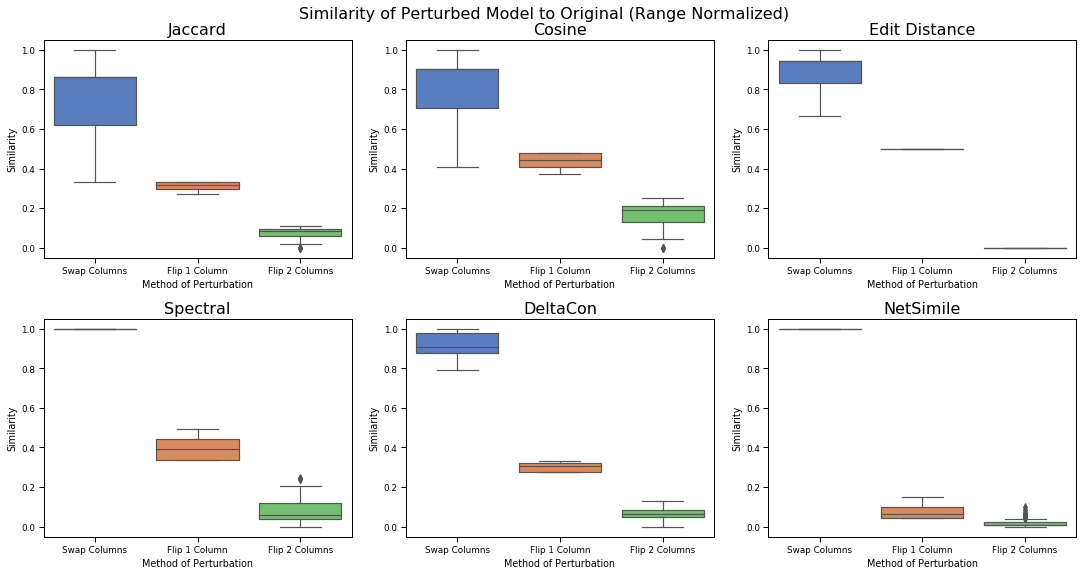

In [61]:
sns.set_context("paper")
sns.set_palette('muted')
f, axes = plt.subplots(2, 3, figsize=(15,8), constrained_layout=True)
sns.boxplot(data=range_normalize(df1).T, order=['Swap Columns','Flip 1 Column','Flip 2 Columns'], ax=axes[1,0])
sns.boxplot(data=range_normalize(df2).T, order=['Swap Columns','Flip 1 Column','Flip 2 Columns'], ax=axes[0,2])
sns.boxplot(data=range_normalize(df3).T, order=['Swap Columns','Flip 1 Column','Flip 2 Columns'], ax=axes[1,1])
sns.boxplot(data=range_normalize(df4).T, order=['Swap Columns','Flip 1 Column','Flip 2 Columns'], ax=axes[0,0])
sns.boxplot(data=range_normalize(df5).T, order=['Swap Columns','Flip 1 Column','Flip 2 Columns'], ax=axes[0,1])
sns.boxplot(data=range_normalize(df6).T, order=['Swap Columns','Flip 1 Column','Flip 2 Columns'], ax=axes[1,2])
axes[0,0].set_title("Jaccard", fontsize=16)
axes[0,1].set_title("Cosine", fontsize=16)
axes[0,2].set_title("Edit Distance", fontsize=16)
axes[1,0].set_title("Spectral", fontsize=16)
axes[1,1].set_title("DeltaCon", fontsize=16)
axes[1,2].set_title("NetSimile", fontsize=16)
for i in range(0,2):
    for j in range(0,3):
        axes[i,j].set(ylabel = "Similarity", xlabel = "Method of Perturbation")
f.suptitle("Similarity of Perturbed Model to Original (Range Normalized)", fontsize=16);

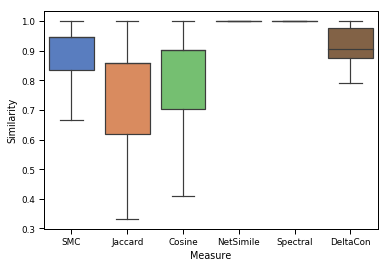

In [62]:
sns.set_context("paper")
sns.set_palette('muted')
df1t = range_normalize(df1).T
df1t['Measure'] = 'Spectral'
df3t = range_normalize(df3).T
df3t['Measure'] = 'DeltaCon'
df4t = range_normalize(df4).T
df4t['Measure'] = 'Jaccard'
df5t = range_normalize(df5).T
df5t['Measure'] = 'Cosine'
df6t = range_normalize(df6).T
df6t['Measure'] = 'NetSimile'
df7t = range_normalize(df7).T
df7t['Measure'] = 'SMC'
fulldf = pd.concat([df1t, df3t, df4t, df5t, df6t, df7t])
sns.boxplot(data=fulldf, x = 'Measure', y = 'Swap Columns', order=['SMC','Jaccard','Cosine','NetSimile','Spectral','DeltaCon'])
plt.ylabel('Similarity');

# Subgraph matching

In [23]:
match_size = range(2,14)
trials = 100

In [24]:
##try new method - swapping or negating rows to test global vs local structure (only done on one functional model)
subgraph_match = {}
random_match = {}
graphs_sm = {}
adj_matrices_sm = {}
graphs_rm = {}
adj_matrices_rm = {}
#index = "Wing Wave Generator"
original = energyharvestertensor.loc[index].unstack()
orig_df = pd.concat([original, original.T], sort=True).fillna(0).sort_index()
orig_g = nx.from_numpy_matrix(orig_df.values)
orig_adj = nx.adjacency_matrix(orig_g)

#sourcename = "Seiko Kinetic watch"
source = energyharvestertensor.loc[sourcename].unstack()
source_df = pd.concat([source, source.T], sort=True).fillna(0).sort_index()
source_g = nx.from_numpy_matrix(source_df.values)
source_adj = nx.adjacency_matrix(source_g)

for size in match_size:
    for i in range(0,trials):
        np.random.seed(i)
        name = str(size)+','+str(i)
        modified = original.copy()
        modified2 = original.copy()
        row_ix = np.random.choice(original.shape[0], size**2)
        col_ix = np.random.choice(original.shape[1], size**2)
        for k in range(0,len(row_ix)):
            modified.iloc[row_ix[k], col_ix[k]] = source.iloc[row_ix[k], col_ix[k]]
        random_match[name] = modified
        df2 = pd.concat([random_match[name], random_match[name].T], sort=True).fillna(0).sort_index() 
        graphs_rm[name] = nx.from_numpy_matrix(df2.values)
        adj_matrices_rm[name] = nx.adjacency_matrix(graphs_rm[name])
        mapping = dict(zip(graphs_rm[name], df2.columns.values)) 
        graphs_rm[name] = nx.relabel_nodes(graphs_rm[name], mapping)
        
        np.random.seed(i+trials)
        rowstart = np.random.randint(original.shape[0] - size)
        colstart = np.random.randint(original.shape[1] - size)
        modified2.iloc[rowstart:rowstart+size,colstart:colstart+size] = source.iloc[rowstart:rowstart+size,colstart:colstart+size]
        subgraph_match[name] = modified2
        df2 = pd.concat([subgraph_match[name], subgraph_match[name].T], sort=True).fillna(0).sort_index() 
        graphs_sm[name] = nx.from_numpy_matrix(df2.values)
        adj_matrices_sm[name] = nx.adjacency_matrix(graphs_sm[name])
        mapping = dict(zip(graphs_sm[name], df2.columns.values)) 
        graphs_sm[name] = nx.relabel_nodes(graphs_sm[name], mapping)

In [25]:
df6 = pd.DataFrame()
A1 = orig_adj
A2 = source_adj
origsourcedist = nc.lambda_dist(A1,A2, kind='laplacian')
for key in adj_matrices_rm:
        d1 = nc.lambda_dist(A1,adj_matrices_rm[key],kind='laplacian')
        df6.loc["random_match original", key] = d1
        d2 = nc.lambda_dist(A2, adj_matrices_rm[key], kind='laplacian')
        df6.loc["random_match source", key] = d2 
        d3 = nc.lambda_dist(A1,adj_matrices_sm[key], kind='laplacian')
        df6.loc["subgraph_match original", key] = d3
        d4 = nc.lambda_dist(A2,adj_matrices_sm[key], kind='laplacian')
        df6.loc["subgraph_match source", key] = d4
df6

,"2,0","2,1","2,2","2,3","2,4","2,5","2,6","2,7","2,8","2,9",...,"13,90","13,91","13,92","13,93","13,94","13,95","13,96","13,97","13,98","13,99"
random_match original,0.000000,0.747147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.230324,2.402355,1.810490,2.082701,1.643920,1.488369,1.752402,1.455785,0.902735,1.211589
random_match source,0.408269,0.862763,0.408269,0.408269,0.408269,0.408269,0.408269,0.408269,0.408269,0.408269,...,1.167444,2.435392,1.670056,2.028887,1.495228,1.528881,1.670094,1.470080,0.995030,1.173748
subgraph_match original,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.713850,0.000000,0.000000,...,1.351955,3.238408,1.750027,2.212151,3.238408,3.238408,1.035527,2.212151,3.238408,1.175924
subgraph_match source,0.408269,0.408269,0.408269,0.408269,0.408269,0.408269,0.408269,0.850458,0.408269,0.408269,...,1.263178,3.217683,1.689258,2.169594,3.217683,3.217683,1.000321,2.169594,3.217683,1.070533


In [26]:
def reformat_for_plot(data):
    indexrow = [int(item.split(',')[0]) for item in list(data.columns.values)]
    new = data.loc[["random_match original", "subgraph_match original"],:]
    new = range_normalize(new)
    new.loc["size",:] = indexrow
    new = pd.melt(new.T, id_vars=['size'])
    new['value']=new['value'].astype(float)
    return new
def reformat_for_plot2(data, origsourcedist):
    indexrow = [int(item.split(',')[0]) for item in list(data.columns.values)]
    new = data.loc[["random_match source", "subgraph_match source"],:]
    new = 1 - ((new - new.min().min())/(new.max().max() - new.min().min()))
    new.loc["size",:] = indexrow
    new = pd.melt(new.T, id_vars=['size'])
    new['value']=new['value'].astype(float)
    return new

In [27]:
df7 = pd.DataFrame()
A1 = orig_adj
A2 = source_adj
origsourcedist = nc.edit_distance(A1, A2)
for key in adj_matrices_rm:
        d1 = nc.edit_distance(A1,adj_matrices_rm[key])
        df7.loc["random_match original", key] = d1
        d2 = nc.edit_distance(A2, adj_matrices_rm[key])
        df7.loc["random_match source", key] = d2 
        d3 = nc.edit_distance(A1,adj_matrices_sm[key])
        df7.loc["subgraph_match original", key] = d3
        d4 = nc.edit_distance(A2,adj_matrices_sm[key])
        df7.loc["subgraph_match source", key] = d4
df7

,"2,0","2,1","2,2","2,3","2,4","2,5","2,6","2,7","2,8","2,9",...,"13,90","13,91","13,92","13,93","13,94","13,95","13,96","13,97","13,98","13,99"
random_match original,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,8.0,11.0,7.0,5.0,10.0,8.0,8.0,3.0,6.0
random_match source,18.0,17.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,...,12.0,10.0,7.0,11.0,13.0,8.0,10.0,10.0,15.0,12.0
subgraph_match original,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,5.0,7.0,6.0,9.0,7.0,7.0,7.0,9.0,7.0,7.0
subgraph_match source,18.0,18.0,18.0,18.0,18.0,18.0,18.0,17.0,18.0,18.0,...,13.0,11.0,12.0,9.0,11.0,11.0,11.0,9.0,11.0,11.0


In [28]:
df8 = pd.DataFrame()
A1 = orig_adj
A2 = source_adj
origsourcedist = (A1,A2)
for key in adj_matrices_rm:
        d1 = nc.deltacon0(A1,adj_matrices_rm[key])
        df8.loc["random_match original", key] = d1
        d2 = nc.deltacon0(A2, adj_matrices_rm[key])
        df8.loc["random_match source", key] = d2 
        d3 = nc.deltacon0(A1,adj_matrices_sm[key])
        df8.loc["subgraph_match original", key] = d3
        d4 = nc.deltacon0(A2,adj_matrices_sm[key])
        df8.loc["subgraph_match source", key] = d4
df8

,"2,0","2,1","2,2","2,3","2,4","2,5","2,6","2,7","2,8","2,9",...,"13,90","13,91","13,92","13,93","13,94","13,95","13,96","13,97","13,98","13,99"
random_match original,0.00000,2.735855,0.00000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.00000,...,17.411515,20.626421,26.412047,14.654526,16.657970,22.989521,21.346807,18.003402,5.603244,17.384919
random_match source,33.00493,30.279704,33.00493,33.00493,33.00493,33.00493,33.00493,33.004930,33.00493,33.00493,...,26.924534,17.282311,14.042782,24.951794,21.859470,15.094363,23.811754,18.382373,28.477681,24.439393
subgraph_match original,0.00000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000,1.579914,0.00000,0.00000,...,13.100322,18.221626,15.385700,20.141965,18.221626,18.221626,18.353796,20.141965,18.221626,14.832249
subgraph_match source,33.00493,33.004930,33.00493,33.00493,33.00493,33.00493,33.00493,31.429081,33.00493,33.00493,...,22.655608,21.838299,23.189029,19.647480,21.838299,21.838299,19.091816,19.647480,21.838299,20.077387


In [29]:
df9 = pd.DataFrame()
A1 = original.to_numpy().flatten()
A2 = source.to_numpy().flatten()
origsourcedist = scipy.spatial.distance.jaccard(A1,A2)
for key in adj_matrices_rm:
        d1 = scipy.spatial.distance.jaccard(A1,random_match[key].to_numpy().flatten())
        df9.loc["random_match original", key] = d1
        d2 = scipy.spatial.distance.jaccard(A2,random_match[key].to_numpy().flatten())
        df9.loc["random_match source", key] = d2 
        d3 = scipy.spatial.distance.jaccard(A1,subgraph_match[key].to_numpy().flatten())
        df9.loc["subgraph_match original", key] = d3
        d4 = scipy.spatial.distance.jaccard(A2,subgraph_match[key].to_numpy().flatten())
        df9.loc["subgraph_match source", key] = d4
df9

,"2,0","2,1","2,2","2,3","2,4","2,5","2,6","2,7","2,8","2,9",...,"13,90","13,91","13,92","13,93","13,94","13,95","13,96","13,97","13,98","13,99"
random_match original,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.375000,0.533333,0.578947,0.388889,0.333333,0.588235,0.444444,0.444444,0.200000,0.375000
random_match source,0.818182,0.809524,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,...,0.631579,0.625000,0.411765,0.550000,0.684211,0.500000,0.526316,0.526316,0.714286,0.631579
subgraph_match original,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,...,0.333333,0.500000,0.400000,0.562500,0.500000,0.500000,0.411765,0.562500,0.500000,0.437500
subgraph_match source,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.818182,0.809524,0.818182,0.818182,...,0.684211,0.687500,0.666667,0.562500,0.687500,0.687500,0.578947,0.562500,0.687500,0.611111


In [30]:
df10 = pd.DataFrame()
A1 = original.to_numpy().flatten()
A2 = source.to_numpy().flatten()
origsourcedist = scipy.spatial.distance.cosine(A1,A2)
for key in adj_matrices_rm:
        d1 = scipy.spatial.distance.cosine(A1, random_match[key].to_numpy().flatten())
        df10.loc["random_match original", key] = d1
        d2 = scipy.spatial.distance.cosine(A2, random_match[key].to_numpy().flatten())
        df10.loc["random_match source", key] = d2 
        d3 = scipy.spatial.distance.cosine(A1, subgraph_match[key].to_numpy().flatten())
        df10.loc["subgraph_match original", key] = d3
        d4 = scipy.spatial.distance.cosine(A2,subgraph_match[key].to_numpy().flatten())
        df10.loc["subgraph_match source", key] = d4
df10

,"2,0","2,1","2,2","2,3","2,4","2,5","2,6","2,7","2,8","2,9",...,"13,90","13,91","13,92","13,93","13,94","13,95","13,96","13,97","13,98","13,99"
random_match original,0.000000,0.039231,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.230769,0.352850,0.407001,0.237287,0.199359,0.414631,0.283885,0.283885,0.110501,0.230769
random_match source,0.692308,0.679744,0.692308,0.692308,0.692308,0.692308,0.692308,0.692308,0.692308,0.692308,...,0.461538,0.445300,0.258751,0.375962,0.519616,0.331006,0.355497,0.355497,0.555250,0.461538
subgraph_match original,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.039231,0.000000,0.000000,...,0.199359,0.313594,0.247382,0.386059,0.313594,0.313594,0.258751,0.386059,0.313594,0.279423
subgraph_match source,0.692308,0.692308,0.692308,0.692308,0.692308,0.692308,0.692308,0.679744,0.692308,0.692308,...,0.519616,0.509710,0.498255,0.386059,0.509710,0.509710,0.407001,0.386059,0.509710,0.439551


Text(0.5,0.98,'Similarity of Perturbed Model to Source (Range Normalized)')

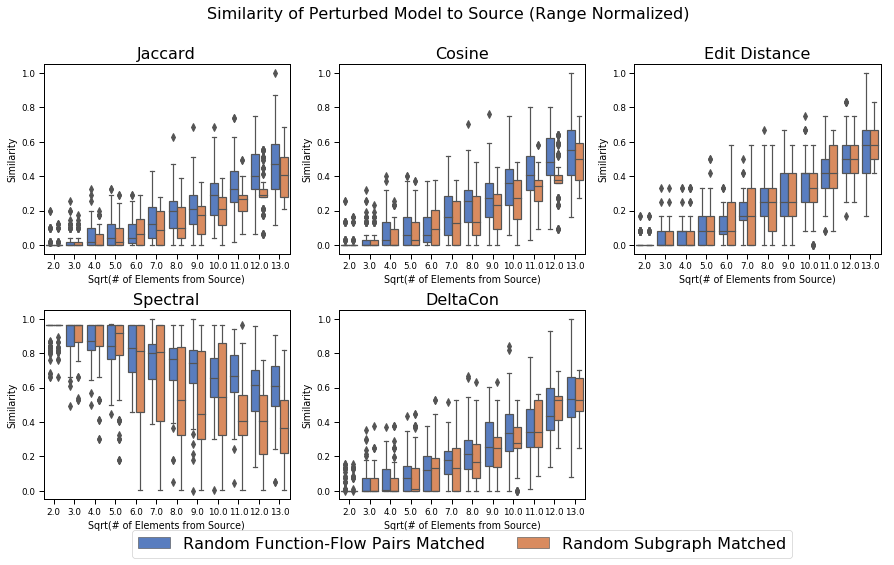

In [31]:
sns.set_context("paper")
sns.set_palette('muted')
f, axes = plt.subplots(2, 3, figsize=(15,8))
sns.boxplot(data=reformat_for_plot2(df6, origsourcedist), x='size',y='value', hue='variable', ax=axes[1,0])
sns.boxplot(data=reformat_for_plot2(df7, origsourcedist), x='size',y='value', hue='variable', ax=axes[0,2])
sns.boxplot(data=reformat_for_plot2(df8, origsourcedist), x='size',y='value', hue='variable', ax=axes[1,1])
sns.boxplot(data=reformat_for_plot2(df9, origsourcedist), x='size',y='value', hue='variable', ax=axes[0,0])
sns.boxplot(data=reformat_for_plot2(df10, origsourcedist), x='size',y='value', hue='variable', ax=axes[0,1])
axes[0,0].set_title("Jaccard", fontsize=16)
axes[0,1].set_title("Cosine", fontsize=16)
axes[0,2].set_title("Edit Distance", fontsize=16)
axes[1,0].set_title("Spectral", fontsize=16)
axes[1,1].set_title("DeltaCon", fontsize=16)
axes[1,2].axis('off')
axes[0,0].get_legend().remove()
axes[0,1].get_legend().remove()
axes[0,2].get_legend().remove()
axes[1,0].get_legend().remove()
for i in range(0,2):
    for j in range(0,3):
        axes[i,j].set(ylabel = "Similarity", xlabel = "Sqrt(# of Elements from Source)")
axes[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3, prop={'size': 16})
leg = axes[1,1].get_legend()
new_labels = ['Random Function-Flow Pairs Matched','Random Subgraph Matched']
for t, l in zip(leg.texts, new_labels): t.set_text(l)
f.subplots_adjust(hspace=0.3)
f.suptitle("Similarity of Perturbed Model to Source (Range Normalized)", fontsize=16)

# Drawing Random Bipartite Graph

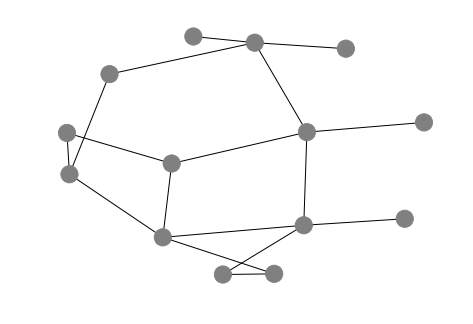

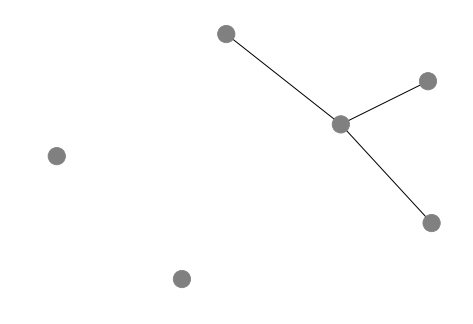

In [82]:
from networkx.algorithms import bipartite
q = nx.algorithms.bipartite.generators.random_graph(8,6,0.35)
#X, Y = bipartite.sets(q)
#pos = dict()
#pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
#pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
#nx.draw(q, pos=pos, node_color=['blue','blue','blue','blue','blue','blue','blue', 'blue','blue','blue','blue','blue','blue','blue'])
nx.draw(q, node_color=['grey','grey','grey','grey','grey','grey','grey', 'grey','grey','grey','grey','grey','grey','grey'])
#plt.savefig("FullGraphEx3.png", format="PNG")
plt.show()
z = nx.algorithms.bipartite.generators.random_graph(5,1,0.6)
nx.draw(z, node_color=['grey','grey','grey','grey','grey'])
plt.savefig("SubGraphEx4.png", format="PNG")
plt.show()

# Subgraph matching 2

In [6]:
def spectraldist(A1,A2):
    d = nc.lambda_dist(A1,A2,kind='laplacian')
    return d
def deltacondist(A1,A2):
    d = nc.deltacon0(A1,A2)
    return d
def netsimdist(A1,A2):
    d = nc.netsimile(A1,A2)
    return d
def jaccarddist(A1,A2):
    A1 = A1.to_numpy().flatten()
    A2 = A2.to_numpy().flatten()
    d = scipy.spatial.distance.jaccard(A1,A2)
    return d
def hammingdist(A1,A2):
    A1 = A1.to_numpy().flatten()
    A2 = A2.to_numpy().flatten()
    d = scipy.spatial.distance.hamming(A1,A2)
    return d
def cosinedist(A1,A2):
    A1 = A1.to_numpy().flatten()
    A2 = A2.to_numpy().flatten()
    d = scipy.spatial.distance.cosine(A1,A2)
    return d

def subgraph_exploration(data, fun, distfn, t):
    subgraphcomp = pd.DataFrame()
    for subg_index in data.index.values:
        subg = data.loc[subg_index].unstack()
        subg.loc[subg.index != fun,:] = 0
        subg_df = pd.concat([subg, subg.T], sort=True).fillna(0).sort_index()
        subg_g = nx.from_numpy_matrix(subg_df.values)
        subg_adj = nx.adjacency_matrix(subg_g)
        for full_index in data.index.values:
            original = data.loc[full_index].unstack()
            orig_df = pd.concat([original, original.T], sort=True).fillna(0).sort_index()
            orig_g = nx.from_numpy_matrix(orig_df.values)
            orig_adj = nx.adjacency_matrix(orig_g)
            if t == 'network':
                d = distfn(orig_adj,subg_adj)
            else:
                d = distfn(original,subg)
            subgraphcomp.loc[subg_index+'_sg', full_index] = d
            
    subgraphonlycomp = pd.DataFrame()
    for subg_index in data.index.values:
        subg = data.loc[subg_index].unstack()
        subg.loc[subg.index != fun,:] = 0
        subg_df = pd.concat([subg, subg.T], sort=True).fillna(0).sort_index()
        subg_g = nx.from_numpy_matrix(subg_df.values)
        subg_adj = nx.adjacency_matrix(subg_g)
        for full_index in data.index.values:
            original = data.loc[full_index].unstack()
            original.loc[original.index != fun,:] = 0
            orig_df = pd.concat([original, original.T], sort=True).fillna(0).sort_index()
            orig_g = nx.from_numpy_matrix(orig_df.values)
            orig_adj = nx.adjacency_matrix(orig_g)
            if t == 'network':
                d = distfn(orig_adj,subg_adj)
            else:
                d = distfn(original,subg)
            subgraphonlycomp.loc[subg_index+'_sg', full_index+'_sg'] = d
            
    return subgraphcomp, subgraphonlycomp

#subgraphcomp, subgraphonlycomp = subgraph_exploration(energyharvestertensor, 'Separate',hammingdist,'vector')

In [11]:
def subg_corrplot(data, distfn, t):
    fn_models = list(data.columns.levels[0])
    corrs = pd.DataFrame()
    for fn in fn_models:
        subgraphcomp, subgraphonlycomp = subgraph_exploration(data, fn, distfn, t)
        sorted_1 = range_normalize(subgraphcomp)
        sorted_2 = range_normalize(subgraphonlycomp)
        for i in range(0,39):
            rankingcorr = sorted_1[sorted_1.columns[i]].corr(sorted_2[sorted_2.columns[i]], method='kendall')
            corrs.loc[fn, i] = rankingcorr
    return corrs

In [12]:
corrs = subg_corrplot(energyharvestertensor, spectraldist, 'network')
corrs2 = subg_corrplot(energyharvestertensor, cosinedist, 'vector') 
corrs3 = subg_corrplot(energyharvestertensor, deltacondist, 'network') 
corrs4 = subg_corrplot(energyharvestertensor, hammingdist, 'vector') 
corrs5 = subg_corrplot(energyharvestertensor, jaccarddist, 'vector') 
corrs6 = subg_corrplot(energyharvestertensor, netsimdist, 'network')

C:\Users\nandy\Anaconda3\envs\test_env\lib\site-packages\scipy\spatial\distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


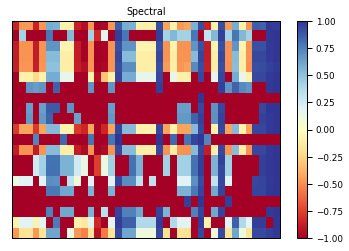

In [52]:
figs = plt.figure()
plt.imshow(corrs, vmin=-1, vmax=1, cmap ="RdYlBu", aspect='auto')
plt.xticks([]),plt.yticks([])
plt.title('Spectral')
plt.colorbar();
figs.savefig('SpectralSubgraphCorr.pdf', dpi=300)

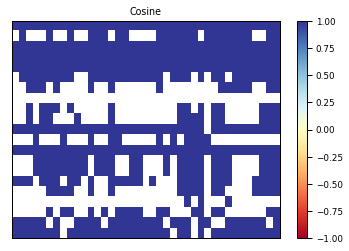

In [53]:
figc = plt.figure()
plt.imshow(corrs2, vmin=-1, vmax=1, cmap ="RdYlBu", aspect='auto')
plt.xticks([]),plt.yticks([])
plt.title('Cosine')
plt.colorbar();
figc.savefig('CosineSubgraphCorr.pdf', dpi=300)

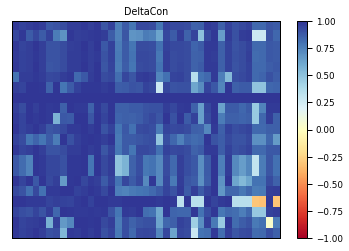

In [55]:
figdc = plt.figure()
plt.imshow(corrs3, vmin=-1, vmax=1, cmap ="RdYlBu", aspect='auto')
plt.xticks([]),plt.yticks([])
plt.title('DeltaCon')
plt.colorbar();
figdc.savefig('DeltaConSubgraphCorr.pdf', dpi=300)

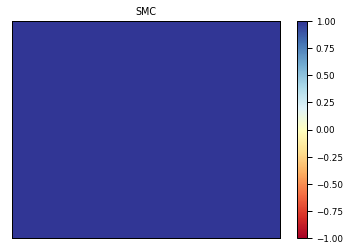

In [56]:
figsmc = plt.figure()
plt.imshow(corrs4, vmin=-1, vmax=1, cmap ="RdYlBu", aspect='auto')
plt.xticks([]),plt.yticks([])
plt.title('SMC')
plt.colorbar();
figsmc.savefig('SMCSubgraphCorr.pdf', dpi=300)

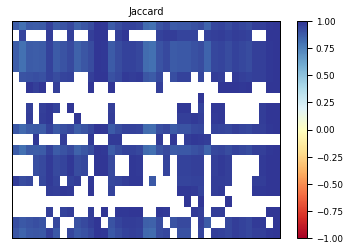

In [57]:
figj = plt.figure()
plt.imshow(corrs5, vmin=-1, vmax=1, cmap ="RdYlBu", aspect='auto')
plt.xticks([]),plt.yticks([])
plt.title('Jaccard')
plt.colorbar();
figj.savefig('JaccardSubgraphCorr.pdf', dpi=300)

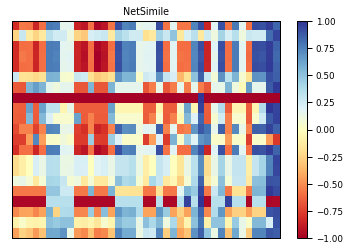

In [58]:
figns = plt.figure()
plt.imshow(corrs6, vmin=-1, vmax=1, cmap ="RdYlBu", aspect='auto')
plt.xticks([]),plt.yticks([])
plt.title('NetSimile')
plt.colorbar();
figns.savefig('NetSimSubgraphCorr.pdf', dpi=300)

# Perturbation 2

In [4]:
def perturbation_exploration(data, product, distfn, t):
    swapped = {}
    graphs_s = {}
    adj_matrices_s = {}
    original = data.loc[product].unstack()
    orig_df = pd.concat([original, original.T], sort=True).fillna(0).sort_index()
    orig_g = nx.from_numpy_matrix(orig_df.values)
    orig_adj = nx.adjacency_matrix(orig_g)

    for j in range(0,original.shape[1]):
        for k in range(0, original.shape[1]):
            if k>j:
                modified = original.copy()
                name = str(j)+str(k)
                cols1, cols2 = modified.iloc[:,j].copy(), modified.iloc[:,k].copy()
                modified.iloc[:,j], modified.iloc[:,k] = cols2.values, cols1.values
                swapped[name] = modified
                df2 = pd.concat([swapped[name], swapped[name].T], sort=True).fillna(0).sort_index() #ADDED a sort - energy harvesters rerun using tag "sorted" ... :(
                graphs_s[name] = nx.from_numpy_matrix(df2.values)
                adj_matrices_s[name] = nx.adjacency_matrix(graphs_s[name])
                mapping = dict(zip(graphs_s[name], df2.columns.values)) 
                graphs_s[name] = nx.relabel_nodes(graphs_s[name], mapping) 
            
    df_out = pd.DataFrame()
    for key in adj_matrices_s:
        A_s = adj_matrices_s[key]
        if t == 'network':
            d = distfn(orig_adj,A_s)
        else:
            d = distfn(original,swapped[key])
        df_out.loc["Swap Columns", key] = d
    return df_out

In [7]:
def perturb_allproducts(input_df, distname, distfn, t):
    output_df = pd.DataFrame()
    for index in input_df.index.values:
        out = range_normalize(perturbation_exploration(input_df, index, distfn, t))
        output_df = pd.concat([output_df, out])
    output_df = output_df.mean(axis=1).to_frame()
    output_df['Measure'] = distname
    return output_df

m1 = perturb_allproducts(energyharvestertensor, 'SMC', hammingdist, 'vector')
m2 = perturb_allproducts(energyharvestertensor, 'Jaccard', jaccarddist, 'vector')
m3 = perturb_allproducts(energyharvestertensor, 'Cosine', cosinedist, 'vector')
m4 = perturb_allproducts(energyharvestertensor, 'NetSimile', netsimdist, 'network')
m5 = perturb_allproducts(energyharvestertensor, 'Spectral', spectraldist, 'network')
m6 = perturb_allproducts(energyharvestertensor, 'DeltaCon', deltacondist, 'network')
fulldf = pd.concat([m1, m2, m3, m4, m5, m6])

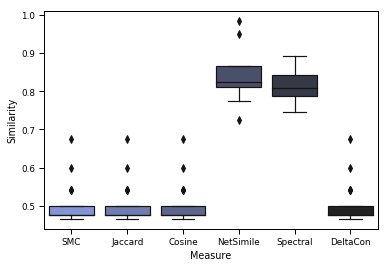

In [9]:
fig1 = plt.figure()
sns.set_context("paper")
sns.set_palette(sns.dark_palette((260, 75, 60), reverse=True, input="husl"))
sns.boxplot(data=fulldf, x = 'Measure', y = 0, order=['SMC','Jaccard','Cosine','NetSimile','Spectral','DeltaCon'])
plt.ylabel('Similarity');
fig1.savefig('Swapping.pdf', dpi=300)